In [41]:
! pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/5b/be/208f17ce87a5e55094b0e8ffd55b06919ab9b56e7e4ce2a64cd9095ec5d2/scikit_learn-1.4.0-1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/d4/b8/7169935f9a2ea9e274ad8c21d6133d492079e6ebc3fc69a915c2375616b0/scipy-1.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 339.1 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cd

## Imports

In [8]:
from scapy.all import rdpcap
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

import seaborn as sns
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder


# Data observation

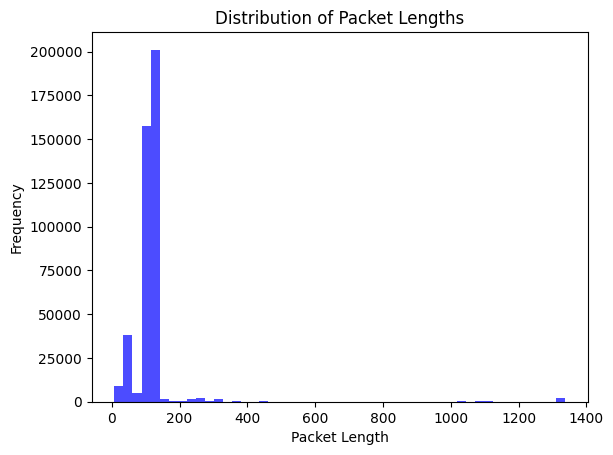

In [23]:
def get_packet_lengths(pcap_file):
    lengths = []

    packets = rdpcap(pcap_file)

    for packet in packets:
        if packet.haslayer('IP'):
            ip_packet = packet['IP']
            
            if ip_packet.haslayer('UDP'):
                udp_packet = ip_packet['UDP']
                
                if udp_packet.haslayer('Raw'):
                    raw_content = udp_packet['Raw'].load
                    lengths.append(len(raw_content))

            elif ip_packet.haslayer('TCP'):
                tcp_packet = ip_packet['TCP']
                
                if tcp_packet.haslayer('Raw'):
                    raw_content = tcp_packet['Raw'].load
                    lengths.append(len(raw_content))

    return lengths

def plot_packet_length_distribution(pcap_file):
    lengths = get_packet_lengths(pcap_file)

    plt.hist(lengths, bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of Packet Lengths')
    plt.xlabel('Packet Length')
    plt.ylabel('Frequency')
    plt.show()

pcap_file_path = 'vpn_hangouts_audio1.pcap'


plot_packet_length_distribution(pcap_file_path)


Processing files:   0%|                                                                                                                                                | 0/11 [00:00<?, ?file/s]

./vpn_facebook_chat1b.pcap


Processing files:   9%|████████████▎                                                                                                                           | 1/11 [00:10<01:42, 10.22s/file]

./vpn_hangouts_audio1.pcap


Processing files:  18%|████████████████████████▌                                                                                                              | 2/11 [07:17<38:21, 255.68s/file]

./vpn_aim_chat1a.pcap


Processing files:  27%|████████████████████████████████████▊                                                                                                  | 3/11 [07:18<18:33, 139.14s/file]

./vpn_hangouts_audio2.pcap


Processing files:  36%|█████████████████████████████████████████████████                                                                                      | 4/11 [12:02<22:54, 196.32s/file]

./vpn_email2b.pcap


Processing files:  45%|█████████████████████████████████████████████████████████████▎                                                                         | 5/11 [12:09<12:49, 128.23s/file]

./vpn_facebook_audio2.pcap


Processing files:  55%|██████████████████████████████████████████████████████████████████████████▏                                                             | 6/11 [12:24<07:28, 89.66s/file]

./vpn_email2a.pcap


Processing files:  64%|██████████████████████████████████████████████████████████████████████████████████████▌                                                 | 7/11 [12:25<04:02, 60.73s/file]

./vpn_hangouts_chat1a.pcap


Processing files:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 8/11 [12:40<02:18, 46.18s/file]

./vpn_ftps_B.pcap


Processing files:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 9/11 [13:20<01:28, 44.09s/file]

./vpn_ftps_A.pcap


Processing files:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 10/11 [14:01<00:43, 43.36s/file]

./vpn_facebook_chat1a.pcap


Processing files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [14:07<00:00, 77.00s/file]


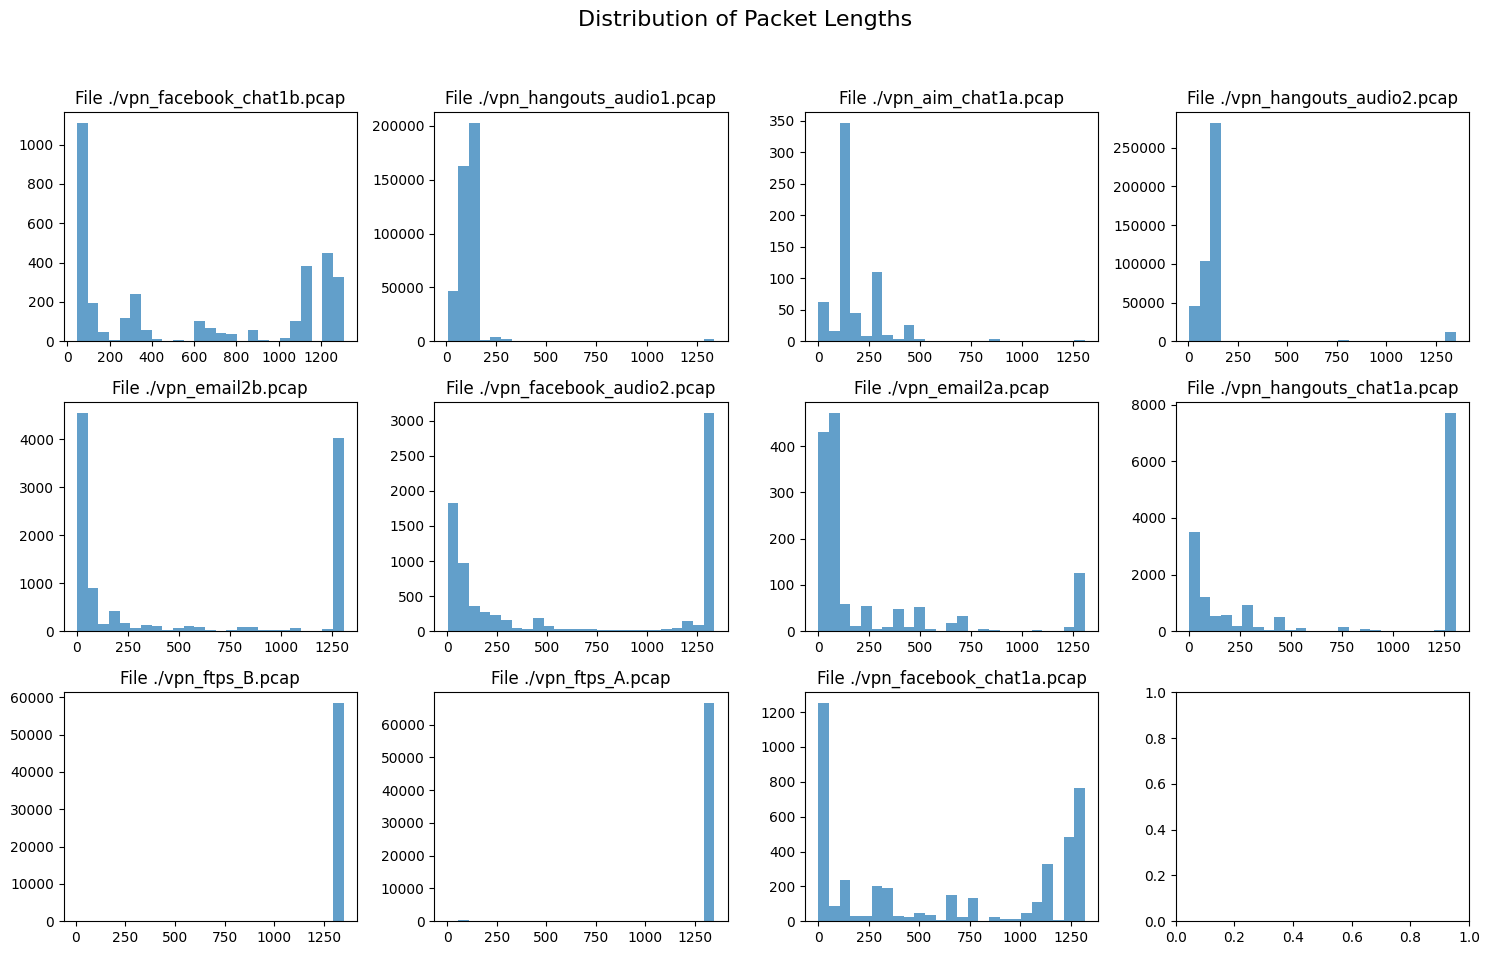

In [26]:
def get_packet_lengths(pcap_file):
    lengths = []

    packets = rdpcap(pcap_file)

    for packet in packets:
        if packet.haslayer('IP'):
            ip_packet = packet['IP']
            
            if ip_packet.haslayer('UDP'):
                udp_packet = ip_packet['UDP']
                
                if udp_packet.haslayer('Raw'):
                    raw_content = udp_packet['Raw'].load
                    lengths.append(len(raw_content))

            elif ip_packet.haslayer('TCP'):
                tcp_packet = ip_packet['TCP']
                
                if tcp_packet.haslayer('Raw'):
                    raw_content = tcp_packet['Raw'].load
                    lengths.append(len(raw_content))

    return lengths

def plot_packet_length_distribution(directory_path):
    pcap_files = [join(directory_path, f) for f in listdir(directory_path) if isfile(join(directory_path, f)) and f.endswith('.pcap')]

    rows = 3
    cols = 4

    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))
    fig.suptitle('Distribution of Packet Lengths', fontsize=16)

    axs = axs.flatten()

    for i, pcap_file in enumerate(tqdm(pcap_files, desc="Processing files", unit="file")):
        print(pcap_file)
        lengths = get_packet_lengths(pcap_file)
        axs[i].hist(lengths, bins=25, alpha=0.7, label=pcap_file)
        axs[i].set_title(f'File {pcap_file}')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

directory_path = '.'

plot_packet_length_distribution(directory_path)


In [37]:
def process_pcap_files(directory_path, output_dir):
    pcap_files = [join(directory_path, f) for f in listdir(directory_path) if isfile(join(directory_path, f)) and f.endswith('.pcap')]

    for pcap_file in pcap_files:
        process_single_pcap_file(pcap_file, output_dir)

def process_single_pcap_file(pcap_file, output_dir):
    packets = rdpcap(pcap_file)
    processed_packets = 0
    skipped_packets = 0
    
    file_name = os.path.join(output_dir, f"{os.path.basename(pcap_file)}.100b.samples")
    with open(file_name, 'wb') as output_file:
        for packet in packets:

            if not packet.haslayer('IP'):
                skipped_packets += 1
                continue
            ip_packet = packet['IP']
            if ip_packet.haslayer('TCP') or ip_packet.haslayer('UDP'):
                if packet.haslayer('Raw'):
                    raw_content = packet['Raw'].load
                        
                    if len(raw_content) < 100:
                        skipped_packets += 1
                        continue

                    middle_index = len(raw_content) // 2
                    extracted_content = raw_content[middle_index-50:middle_index+50]
    
                    output_file.write(extracted_content)
                    processed_packets += 1


    if processed_packets > 0:
        ratio = skipped_packets / processed_packets
        print(f"For {pcap_file}, Skipped/Processed Ratio: {ratio:.2%}")

directory_path = '.'
output_directory = 'outsamples'

process_pcap_files(directory_path, output_directory)


For ./vpn_facebook_chat1b.pcap, Skipped/Processed Ratio: 48.49%
For ./vpn_hangouts_audio1.pcap, Skipped/Processed Ratio: 15.11%
For ./vpn_aim_chat1a.pcap, Skipped/Processed Ratio: 13.90%
For ./vpn_hangouts_audio2.pcap, Skipped/Processed Ratio: 14.40%
For ./vpn_email2b.pcap, Skipped/Processed Ratio: 93.48%
For ./vpn_facebook_audio2.pcap, Skipped/Processed Ratio: 49.56%
For ./vpn_email2a.pcap, Skipped/Processed Ratio: 195.65%
For ./vpn_hangouts_chat1a.pcap, Skipped/Processed Ratio: 40.98%
For ./vpn_ftps_B.pcap, Skipped/Processed Ratio: 0.35%
For ./vpn_ftps_A.pcap, Skipped/Processed Ratio: 0.62%
For ./vpn_facebook_chat1a.pcap, Skipped/Processed Ratio: 45.21%


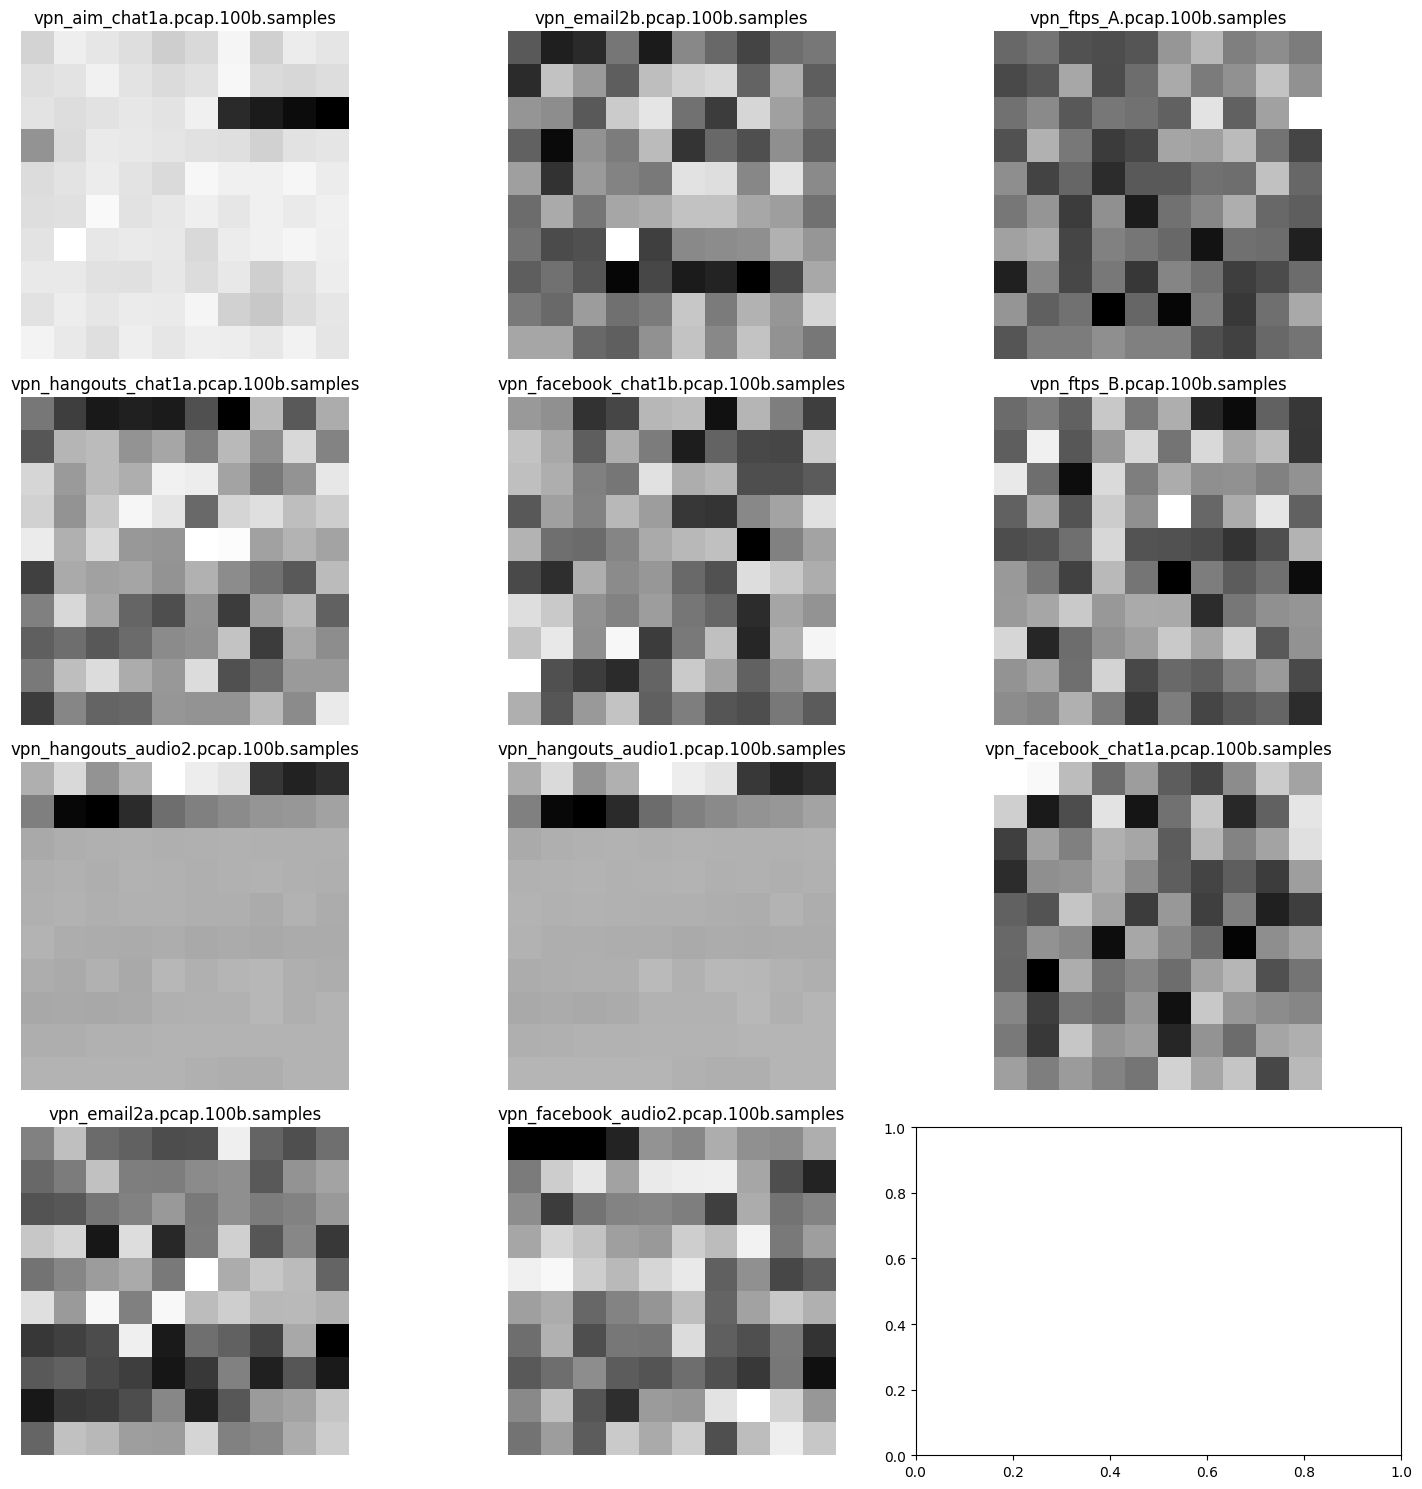

In [39]:
def process_file(file_path):
    with open(file_path, 'rb') as f:
        content = f.read()

    # Split content into chunks of 100 bytes
    chunks = [content[i:i+100] for i in range(0, len(content), 100)]

    # Reshape each chunk to a 10x10 matrix
    matrices = [np.frombuffer(chunk, dtype=np.uint8).reshape((10, 10)) for chunk in chunks]

    # Compute the average matrix
    average_matrix = np.mean(matrices, axis=0)

    return average_matrix

def display_images(files_folder):
    # Path to the folder containing binary files
    folder_path = files_folder

    # Get a list of all files in the folder
    file_list = [file_name for file_name in os.listdir(folder_path) if file_name.endswith('.samples')]

    # Calculate the number of rows and columns for subplots
    num_files = len(file_list)
    num_rows = int(np.ceil(np.sqrt(num_files)))
    num_cols = int(np.ceil(num_files / num_rows))

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    # Iterate through files in the folder
    for i, file_name in enumerate(file_list):
        file_path = os.path.join(folder_path, file_name)

        # Process the file
        average_matrix = process_file(file_path)

        # Display the resulting image in the subplot
        if num_rows > 1 and num_cols > 1:
            ax = axes[i // num_cols, i % num_cols]
        elif num_rows > 1:
            ax = axes[i]
        elif num_cols > 1:
            ax = axes[i]

        ax.imshow(average_matrix, cmap='gray')
        ax.set_title(file_name)
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Call the function with the folder path
display_images(output_directory)


In [2]:

def load_data(folder_path, ignore_variant=False):
    data = []
    labels = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.samples'):

            print(f"Working on file: {file_name}") 
            file_path = os.path.join(folder_path, file_name)

            with open(file_path, 'rb') as f:
                content = f.read()

            # Split content into chunks of 100 bytes
            chunks = [content[i:i+100] for i in range(0, len(content), 100)]

            # Reshape each chunk to a 10x10 matrix
            matrices = [np.frombuffer(chunk, dtype=np.uint8).reshape((10, 10)) for chunk in chunks]

            # Flatten each matrix to a 1D array
            flattened_matrices = [matrix.flatten() for matrix in matrices]

            # Use the filename (excluding the extension) as the label
            label = os.path.splitext(file_name)[0]
            if ignore_variant:
                label = label.replace('1a.', '.')
                label = label.replace('1b.', '.')
                label = label.replace('_A.', '.')
                label = label.replace('_B.', '.')
                label = label.replace('2a.', '.')
                label = label.replace('2b.', '.')
                label = label.replace('2.', '.')
                label = label.replace('1.', '.')

            data.extend(flattened_matrices)
            labels.extend([label] * len(flattened_matrices))

    return np.array(data), np.array(labels)


In [3]:
output_directory = 'outsamples'

# Path to the folder containing binary files
folder_path = output_directory

# Load data and labels
data, labels = load_data(folder_path)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

# Scale the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

"Done"

Working on file: vpn_aim_chat1a.pcap.100b.samples
Working on file: vpn_email2b.pcap.100b.samples
Working on file: vpn_ftps_A.pcap.100b.samples
Working on file: vpn_hangouts_chat1a.pcap.100b.samples
Working on file: vpn_facebook_chat1b.pcap.100b.samples
Working on file: vpn_ftps_B.pcap.100b.samples
Working on file: vpn_hangouts_audio2.pcap.100b.samples
Working on file: vpn_hangouts_audio1.pcap.100b.samples
Working on file: vpn_facebook_chat1a.pcap.100b.samples
Working on file: vpn_email2a.pcap.100b.samples
Working on file: vpn_facebook_audio2.pcap.100b.samples


'Done'

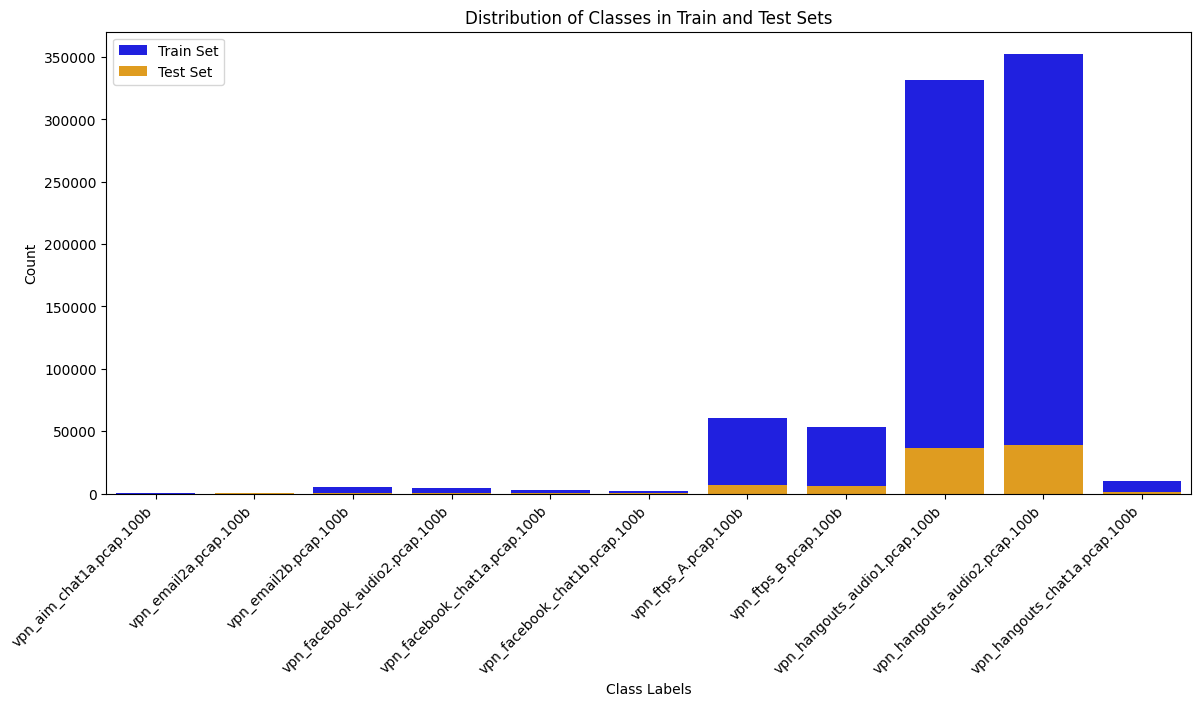

In [10]:

# Count the occurrences of each class in the training and test sets
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

# Plot the distribution of classes
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=train_class_counts[0], y=train_class_counts[1], color='blue', label='Train Set', ax=ax)
sns.barplot(x=test_class_counts[0], y=test_class_counts[1], color='orange', label='Test Set', ax=ax)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

ax.set_xlabel('Class Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in Train and Test Sets')
ax.legend()

plt.show()

In [90]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)

X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_scaled, y_train)

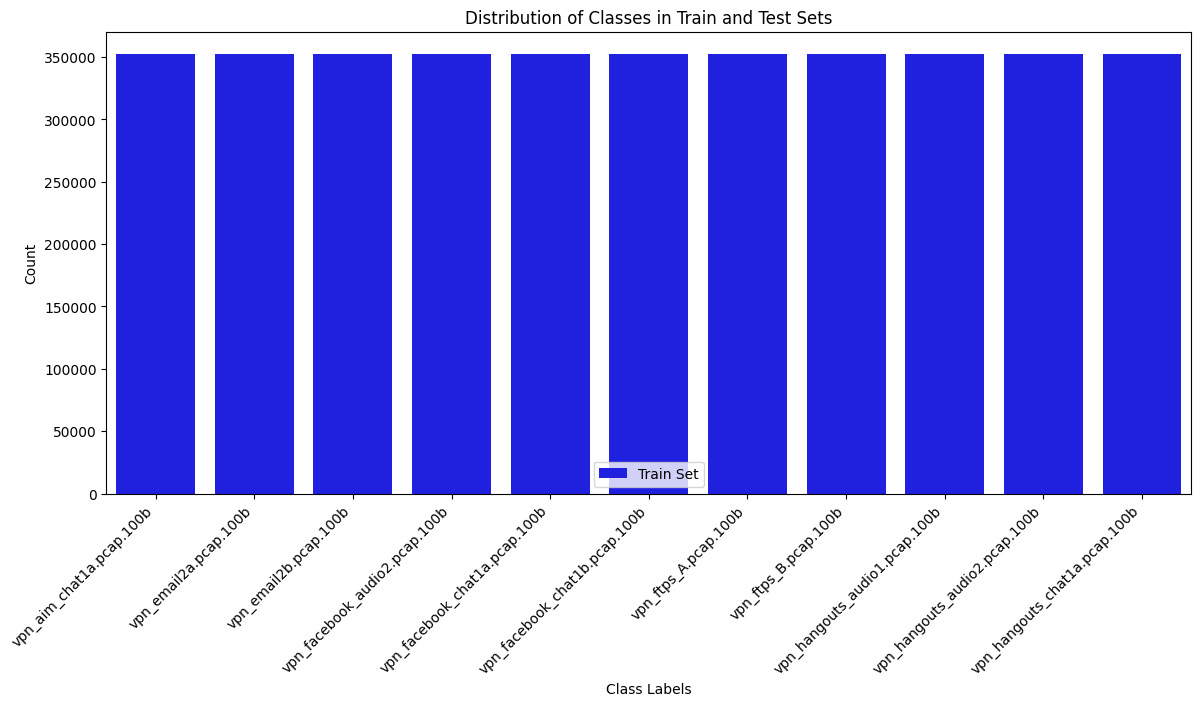

In [91]:
train_class_counts = np.unique(y_train_balanced, return_counts=True)

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=train_class_counts[0], y=train_class_counts[1], color='blue', label='Train Set', ax=ax)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

ax.set_xlabel('Class Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in Train and Test Sets')
ax.legend()

plt.show()

In [66]:
mlp = MLPClassifier(verbose=True, max_iter=20, batch_size=256, random_state=42)
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (40,), (20, 100), (100, 20)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
}

grid_search = GridSearchCV(mlp, param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=10, refit=True)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

# Get the best classifier
best_mlp = grid_search.best_estimator_

print("CV Losses:")
for i, loss in enumerate(grid_search.cv_results_['mean_test_score']):
    print(f"CV Step {i + 1}: {loss}")

y_pred = best_mlp.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/you2ku/venv311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/you2ku/venv311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/you2ku/venv311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/you2ku/venv311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/you2ku/venv311/lib/python3.11/site-package

KeyboardInterrupt: 

In [93]:
mlp = MLPClassifier(verbose=True, hidden_layer_sizes=(20), alpha=0.0001, learning_rate_init=0.001, max_iter=20, batch_size=100, random_state=42)

mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

Iteration 1, loss = 1.01127736
Iteration 2, loss = 0.92662075
Iteration 3, loss = 0.91103102
Iteration 4, loss = 0.90436338
Iteration 5, loss = 0.90003369
Iteration 6, loss = 0.89644794
Iteration 7, loss = 0.89396653
Iteration 8, loss = 0.89216520
Iteration 9, loss = 0.89071610
Iteration 10, loss = 0.88961234
Iteration 11, loss = 0.88874169
Iteration 12, loss = 0.88811321
Iteration 13, loss = 0.88753722
Iteration 14, loss = 0.88668485
Iteration 15, loss = 0.88593697
Iteration 16, loss = 0.88461895
Iteration 17, loss = 0.88352380
Iteration 18, loss = 0.88268791
Iteration 19, loss = 0.88204113
Iteration 20, loss = 0.88154723


/home/you2ku/venv311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4925868869295399


Test Accuracy: 0.4925868869295399


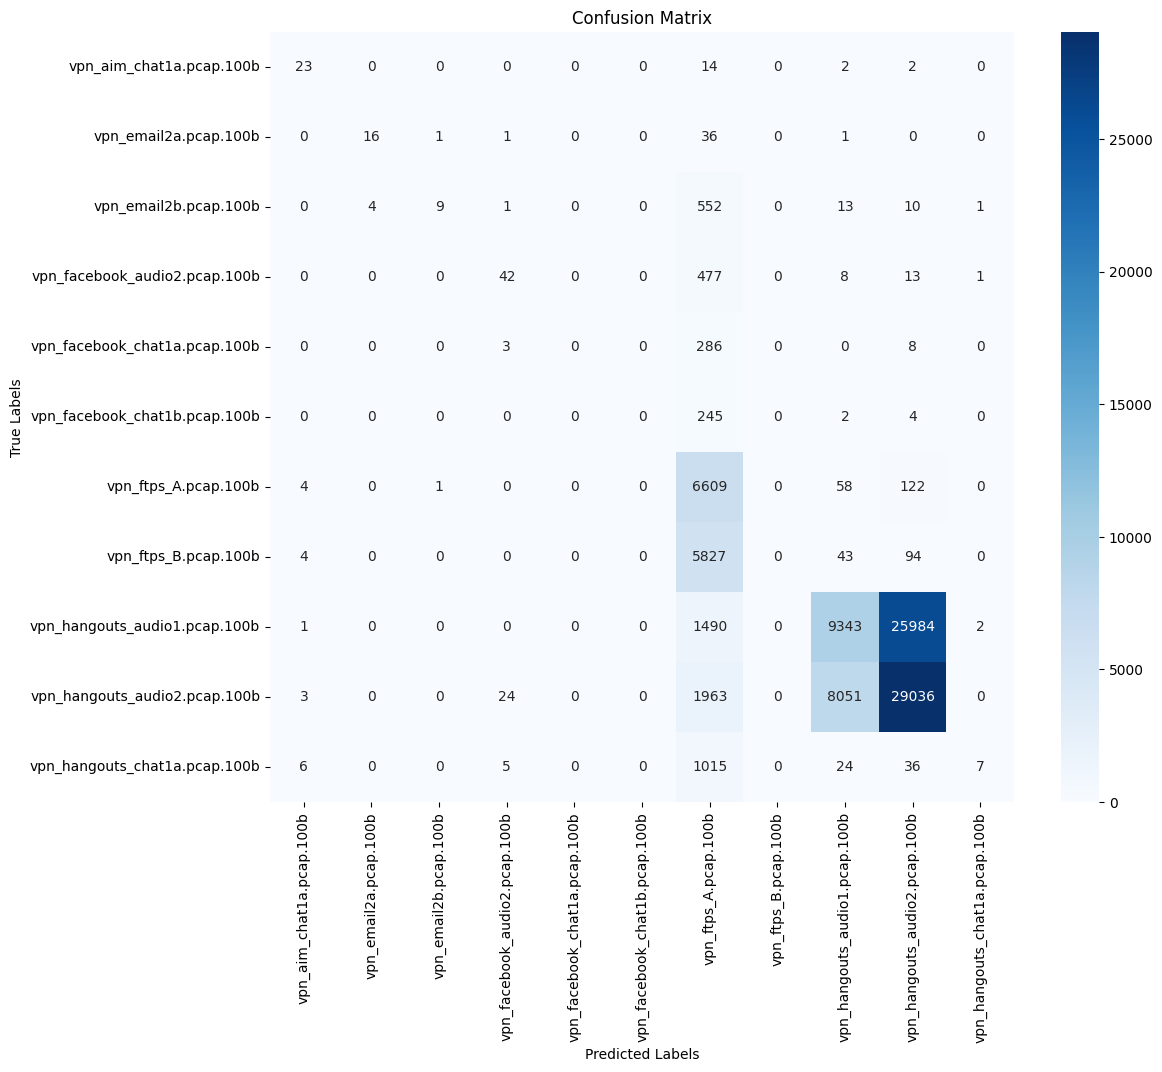

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

conf_mat = confusion_matrix(y_test_encoded, y_pred_encoded)

accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print("Test Accuracy:", accuracy)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [4]:
data, labels = load_data(folder_path, ignore_variant=True)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"Done"

Working on file: vpn_aim_chat1a.pcap.100b.samples
Working on file: vpn_email2b.pcap.100b.samples
Working on file: vpn_ftps_A.pcap.100b.samples
Working on file: vpn_hangouts_chat1a.pcap.100b.samples
Working on file: vpn_facebook_chat1b.pcap.100b.samples
Working on file: vpn_ftps_B.pcap.100b.samples
Working on file: vpn_hangouts_audio2.pcap.100b.samples
Working on file: vpn_hangouts_audio1.pcap.100b.samples
Working on file: vpn_facebook_chat1a.pcap.100b.samples
Working on file: vpn_email2a.pcap.100b.samples
Working on file: vpn_facebook_audio2.pcap.100b.samples


'Done'

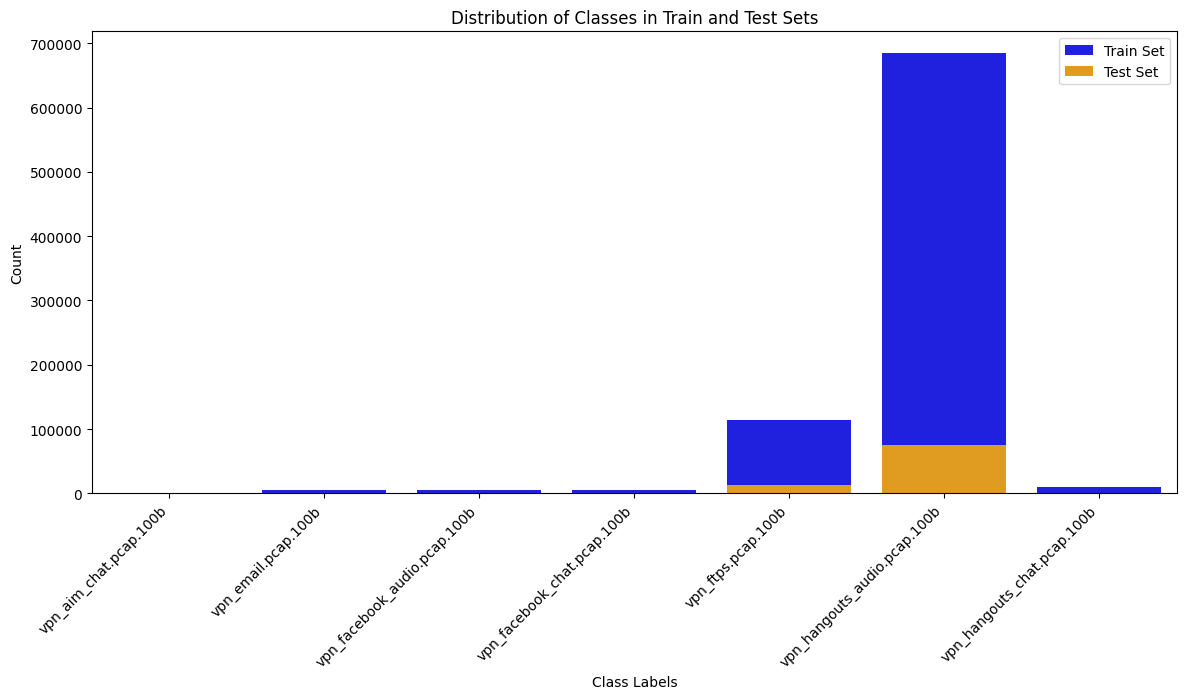

In [6]:

# Count the occurrences of each class in the training and test sets
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

# Plot the distribution of classes
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=train_class_counts[0], y=train_class_counts[1], color='blue', label='Train Set', ax=ax)
sns.barplot(x=test_class_counts[0], y=test_class_counts[1], color='orange', label='Test Set', ax=ax)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

ax.set_xlabel('Class Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in Train and Test Sets')
ax.legend()

plt.show()

In [5]:
from imblearn.under_sampling import RandomUnderSampler
randomS = RandomUnderSampler()
# Fit and transform the training data
X_train_balanced, y_train_balanced = randomS.fit_resample(X_train_scaled, y_train)


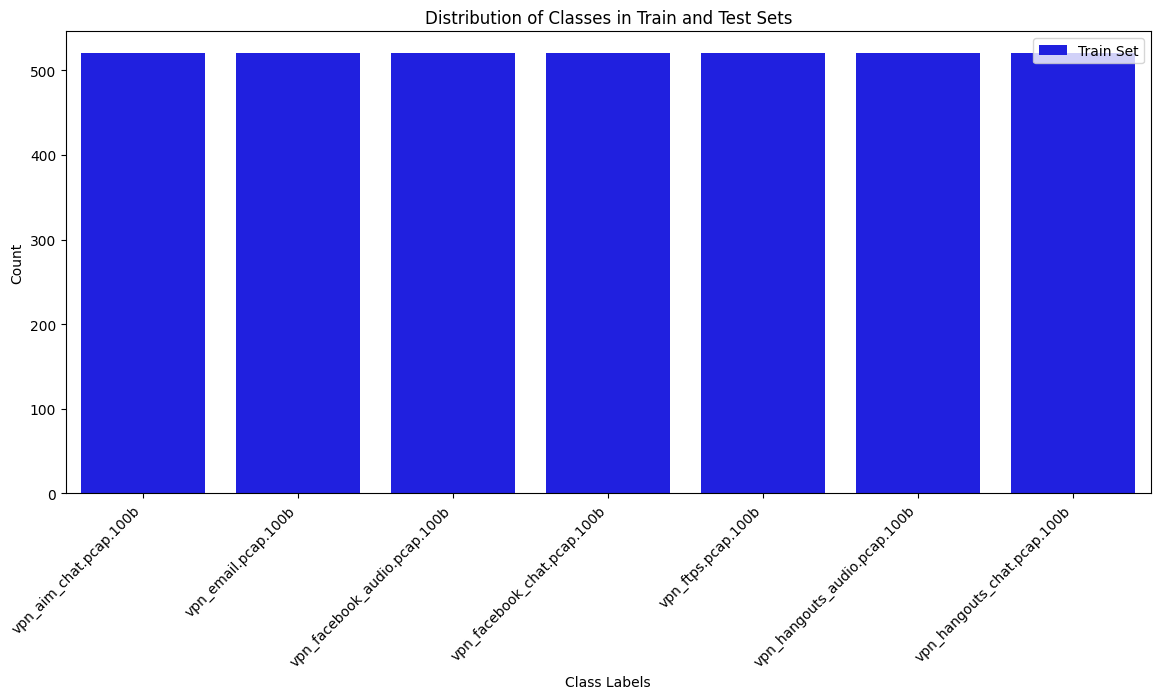

In [6]:
train_class_counts = np.unique(y_train_balanced, return_counts=True)

fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=train_class_counts[0], y=train_class_counts[1], color='blue', label='Train Set', ax=ax)

plt.xticks(rotation=45, ha='right')

ax.set_xlabel('Class Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in Train and Test Sets')
ax.legend()

plt.show()

In [7]:
mlp = MLPClassifier(verbose=True, hidden_layer_sizes=(20), alpha=0.0001, learning_rate_init=0.001, max_iter=20, batch_size=100, random_state=42)

mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

Iteration 1, loss = 0.33013483
Iteration 2, loss = 0.25998299
Iteration 3, loss = 0.24904094
Iteration 4, loss = 0.24312900
Iteration 5, loss = 0.24002544
Iteration 6, loss = 0.23800832
Iteration 7, loss = 0.23620898
Iteration 8, loss = 0.23479378
Iteration 9, loss = 0.23366087
Iteration 10, loss = 0.23254278
Iteration 11, loss = 0.23185066
Iteration 12, loss = 0.23130865
Iteration 13, loss = 0.23096246
Iteration 14, loss = 0.23060622
Iteration 15, loss = 0.23035744
Iteration 16, loss = 0.23023238
Iteration 17, loss = 0.23002089
Iteration 18, loss = 0.22976979
Iteration 19, loss = 0.22950970
Iteration 20, loss = 0.22934186


/home/you2ku/venv311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


0.9277590219279557


Test Accuracy: 0.9277590219279557


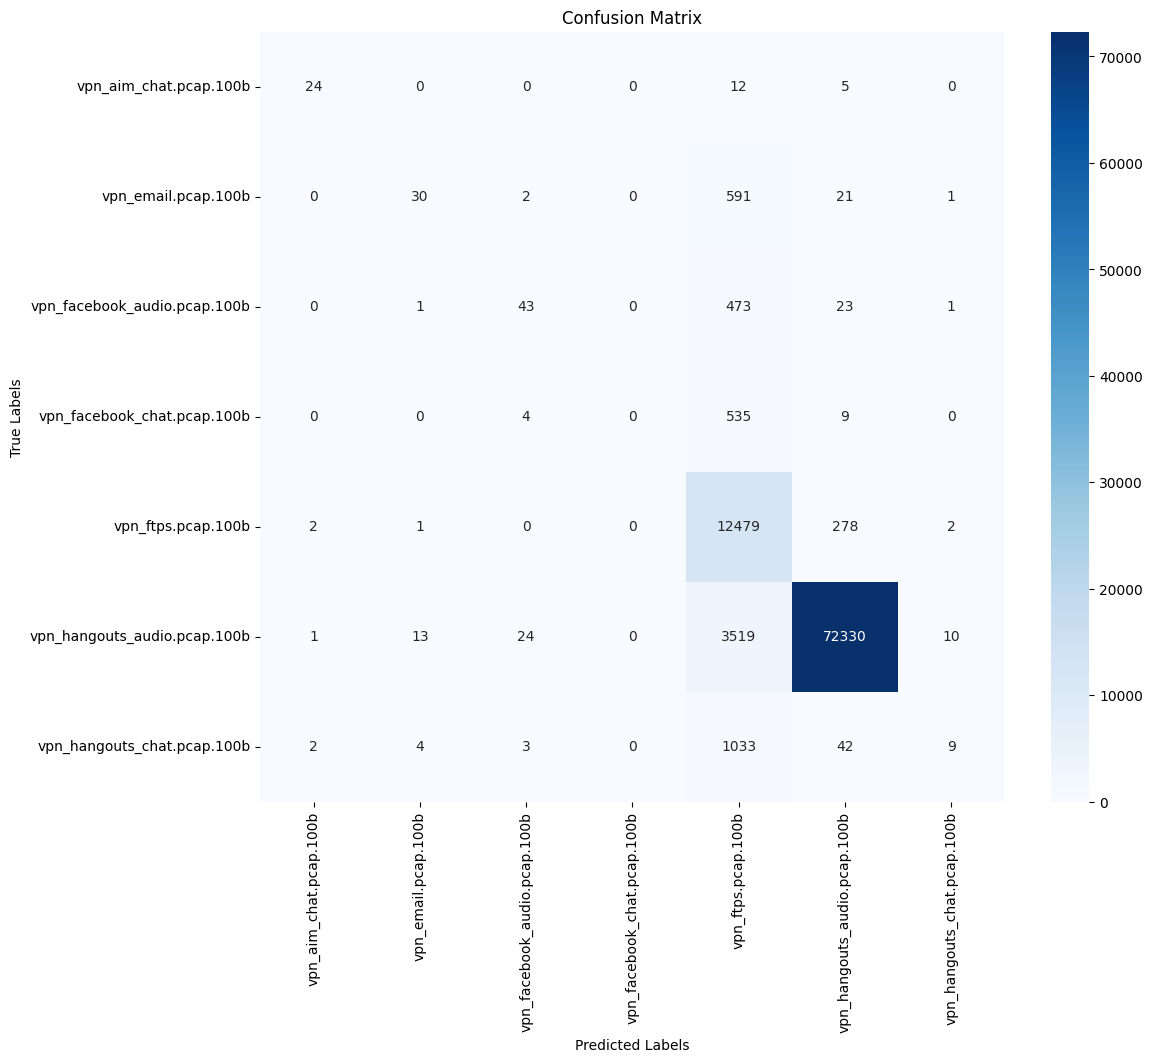

In [9]:
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_encoded = label_encoder.transform(y_pred)

conf_mat = confusion_matrix(y_test_encoded, y_pred_encoded)

accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print("Test Accuracy:", accuracy)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()